# Lecture 24: Second-order optimization

[EE227C course page](https://ee227c.github.io/)  
[Download ipynb file](https://ee227c.github.io/code/lecture24.ipynb)

Overview:

* [Newton iteration](#newton)
* [Logistic regression](#logistic)
* [Newton with approximate least squares](#lsq)
* [BFGS](#bfgs)
* [Hessian-vector products](#hvprod)
* [A more realistic example](#adult)

In [1]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model

np.random.seed(1337)
from timeit import timeit

from optimizers import gradient_descent, gss
from plotters import error_plot, convergence_plot, kwargs, setup_layout

setup_layout()

<a name="newton"></a>

## Newton iteration

Below is a naive implementation of Newton's iteration that we analyzed in the last lecture.

In [2]:
def newton_method(init, steps, grad, hessian, num_to_keep=None):
    """Newton iteration with full Hessian inverse.
    
    Parameters
    ----------
        initial : array
            starting point
        steps : list of floats
            step size schedule for the algorithm
        grad : function
            mapping arrays to arrays of same shape
        hessian : function
            mapping 1d arrays to 2d arrays
        num_to_keep : integer, optional
            number of points to keep
        
    Returns
    -------
        List of points computed by Newton iteration. Length of the
        list is determined by `num_to_keep`.
    """
    xs = [init]
    for step in steps:
        Hinv = np.linalg.pinv(hessian(xs[-1]))
        xs.append(xs[-1] - step * Hinv.dot(grad(xs[-1])))
        if num_to_keep:
          xs = xs[-num_to_keep:]
    return xs

As a sanity check, Newton's method should solve a quadratic in one step. The same is true for least squares.

In [3]:
def least_squares(A, b, x):
    """Least squares objective."""
    return (0.5/len(A)) * np.linalg.norm(A.dot(x)-b)**2

def least_squares_gradient(A, b, x):
    """Gradient of least squares objective at x."""
    return A.T.dot(A.dot(x)-b)/len(A)

def least_squares_hessian(A, x):
    """Hessian of least squares objective."""
    return A.T.dot(A)/len(A)

In [4]:
m, n = 1000, 100
A = np.random.normal(0, 1, (m, n))
x_opt = np.random.normal(0, 1, n)
noise = np.random.normal(0, 0.1, m)
b = A.dot(x_opt)
objective = lambda x: least_squares(A, b, x)
gradient = lambda x: least_squares_gradient(A, b, x)
hessian = lambda x: least_squares_hessian(A, x)
x0 = np.random.normal(0, 1, n)

In [5]:
xs = newton_method(x0, [1], gradient, hessian)
errors = [objective(x) for x in xs]

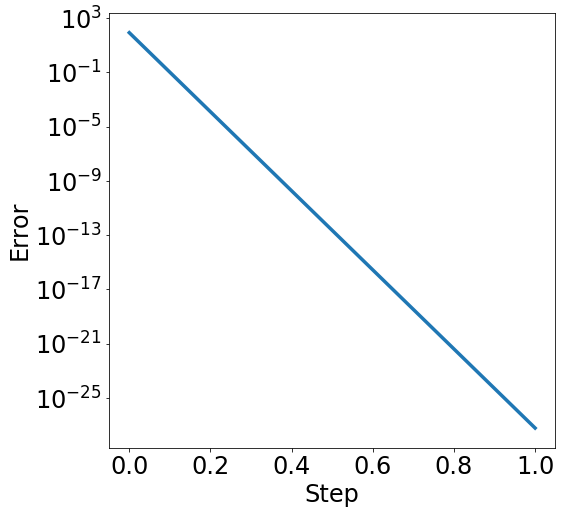

In [6]:
error_plot(errors)

<a name="logistic"></a>

## Logistic regression

Let's move on to a less trivial example that we'll stick to for the rest of the lecture: logistic regression. A logistic model makes predictions based on a sigmoid function applied to a linear function of the data.

In [7]:
def sigmoid(x):
    """Sigmoid function."""
    return 1./(1.+np.exp(-x))

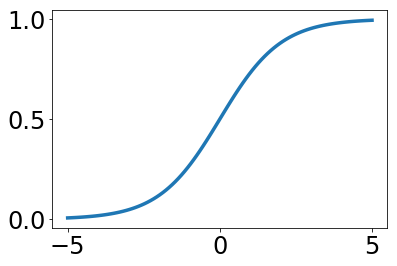

In [8]:
xs = np.linspace(-5, 5, 100)
plt.plot(xs, sigmoid(xs), **kwargs);

In [9]:
def logistic_model(weights, data):
    """Logistic model."""
    return sigmoid(data.dot(weights))

def log_likelihood(weights, data, labels):
    """Normalized negative log likelihood."""
    scores = np.dot(data, weights)
    return -np.mean(labels*scores - np.log(1 + np.exp(scores)))

def log_likelihood_gradient(weights, data, labels):
    """Gradient of negative log likelihood."""
    predictions = logistic_model(weights, data)  
    return -data.T.dot(labels - predictions)/len(data)

def log_likelihood_hessian(weights, data, labels):
    """Hessian of negative log likelihood."""
    predictions = logistic_model(weights, data)
    diag = np.diag(predictions * (1 - predictions))
    return data.T.dot(diag.dot(data))/len(data)

In [10]:
m, n = 1000, 100
data = np.random.normal(0, 1, (m, n))
wopt = np.random.normal(0, 1, n)
labels = (data.dot(wopt) > 0).astype(np.float)
gradient = lambda w: log_likelihood_gradient(w, data, labels)
hessian = lambda w: log_likelihood_hessian(w, data, labels)
init = np.zeros(n)

Let's get a baseline solution out of sklearn's logistic model.

In [11]:
cls = linear_model.LogisticRegression()
cls.fit(data, labels)
weights = np.reshape(cls.coef_, cls.coef_.shape[1])
baseline = log_likelihood(weights, data, labels)
baseline

0.052474218544034071

In [12]:
ws_gd = gradient_descent(init, np.ones(1000), gradient)
ws_newton = newton_method(init, np.ones(10), gradient, hessian)

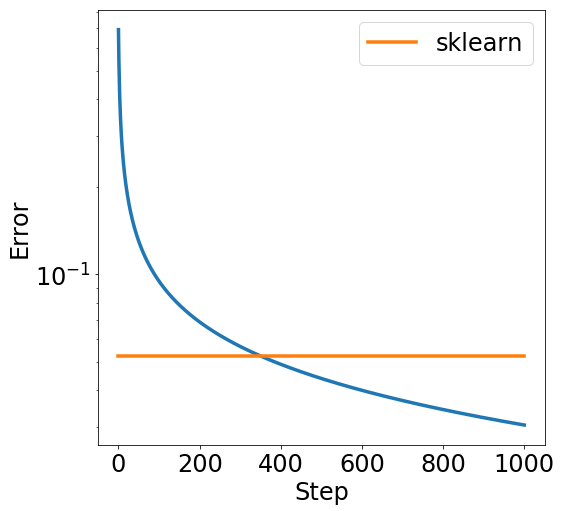

In [13]:
error_plot([log_likelihood(w, data, labels) for w in ws_gd])
plt.plot(range(len(ws_gd)), [baseline]*len(ws_gd),
        label='sklearn', **kwargs)
_ = plt.legend()

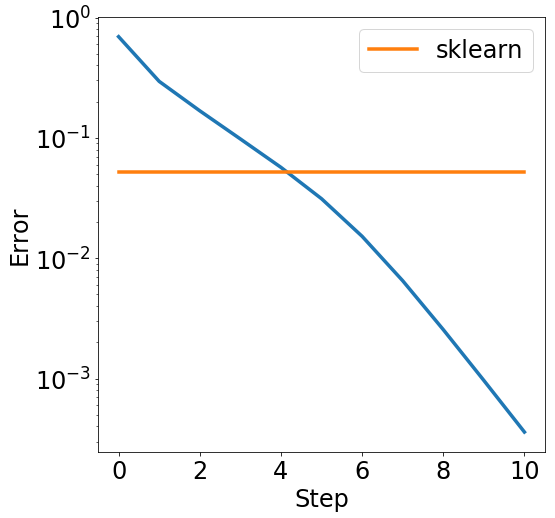

In [14]:
error_plot([log_likelihood(w, data, labels) for w in ws_newton])
plt.plot(range(len(ws_newton)), [baseline]*len(ws_newton),
        label='sklearn', **kwargs)
plt.legend();

<a name="lsq"></a>

## Speed-up via linear equations

We'll now see how to speed up Newton's iteration with a simple trick. Instead of computing a full pseudo-inverse, we'll solve set of a linear equations approximately. Recall that the system $Hx=g$ has the solution $x=H^{-1}g$.

In [15]:
def newton_method_lsq(init, steps, grad, hessian, least_squares, 
                     num_to_keep=None):
    """Newton iteration with least squares solver.
    
    Parameters
    ----------
        initial : array
            starting point
        steps : list of floats
            step size schedule for the algorithm
        grad : function
            mapping arrays to arrays of same shape
        hessian : function
            mapping 1d arrays to 2d arrays
        least_squares : function
            solver for linear equations
        num_to_keep : integer, optional
            number of points to keep
        
    Returns
    -------
        List of points computed by Newton iteration. Length of the
        list is determined by `num_to_keep`.
    """
    xs = [init]
    for step in steps:
        # Use least squares solver for Hessian-gradient product
        direction = least_squares(hessian(xs[-1]), grad(xs[-1]))
        xs.append(xs[-1] - step * direction)
        if num_to_keep:
          xs = xs[-num_to_keep:]
    return xs

If we use a full least squares solve, this is just equivalent to the pseudo-inverse we had before. This why Newton's method for logistic regression is sometimes called **iteratively reweighted least squares**.

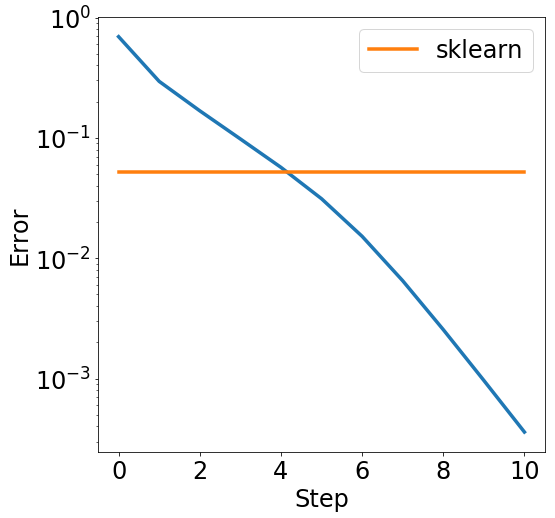

In [16]:
lsq = lambda A, b: np.linalg.lstsq(A, b)[0]
ws_newton_lsq = newton_method_lsq(init, np.ones(10), gradient, hessian, lsq)
error_plot([log_likelihood(w, data, labels) for w in ws_newton_lsq])
plt.plot(range(len(ws_newton_lsq)), [baseline]*len(ws_newton_lsq),
        label='sklearn', **kwargs)
_ = plt.legend()

Let's plug in an approximate solver to see what happens. All the tools for linear equations we've seen in previous lectures (gradient descent, conjugate gradient etc.) could be used here. We'll just stick to gradient descent to keep it simple.

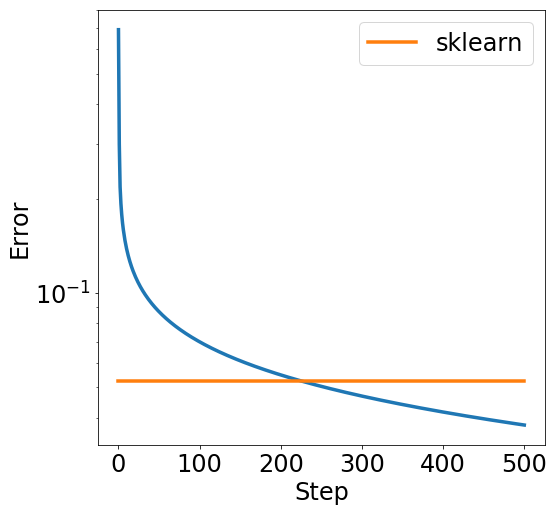

In [17]:
def lsq_gd(A, b):
    """Approximate least squares with gradient descent"""
    gradient = lambda x: least_squares_gradient(A, b, x)
    return gradient_descent(b, 1000*np.ones(10), gradient)[-1]

ws_newton_lsq_gd = newton_method_lsq(init, np.ones(500), gradient, hessian, lsq_gd)
error_plot([log_likelihood(w, data, labels) for w in ws_newton_lsq_gd])
plt.plot(range(len(ws_newton_lsq_gd)), [baseline]*len(ws_newton_lsq_gd),
        label='sklearn', **kwargs)
_ = plt.legend()

It looks like we didn't gain much compared with plain gradient descent. The number of iterations to reach the baseline got smaller, but each iteration is now costlier. Nonetheless, this idea gives rise to set of interesting heuristics.

<a name="bfgs"></a>

## BFGS

In [18]:
def bfgs(init, grad, hessian, line_search, num_steps, num_to_keep=None):
    """BFGS algorithm (toy implementation).
    
    Parameters
    ----------
        initial : array
            starting point
        grad : function
            mapping arrays to arrays of same shape
        hessian : function
            mapping 1d arrays to 2d arrays
        line_search : function
            method to determine step size
        num_steps : number
            number of iterations
        num_to_keep : integer, optional
            number of points to keep
        
    Returns
    -------
        List of points computed by Newton iteration. Length of the
        list is determined by `num_to_keep`.
    """
    xs = [init]
    I = np.eye(len(init))
    Hs = [hessian(init)]
    Hinvs = [I]
    
    for _ in range(num_steps):
        # update point
        direction = Hinvs[-1].dot(grad(xs[-1]))
        step = line_search(xs[-1], direction)
        xs.append(xs[-1] + step * direction)
        
        s = xs[-1] - xs[-2]
        y = grad(xs[-1]) - grad(xs[-2])
        ys = np.dot(y, s)
        ssT = np.outer(s, s)
        
        # udpate H
        H = Hs[-1] + np.outer(y, y)/ys
        H -= Hs[-1].dot(ssT.dot(Hs[-1]))/np.dot(s, Hs[-1].dot(s))
        Hs.append(H)
        
        # update Hinv
        left = I - np.outer(s, y)/ys
        right = I - np.outer(y, s)/ys
        Hinvs.append(left.dot(Hinvs[-1]).dot(right) + ssT/ys)
        
        if num_to_keep:
          xs = xs[-num_to_keep:]
    
    return xs

Let's first try this out with a constant step size.

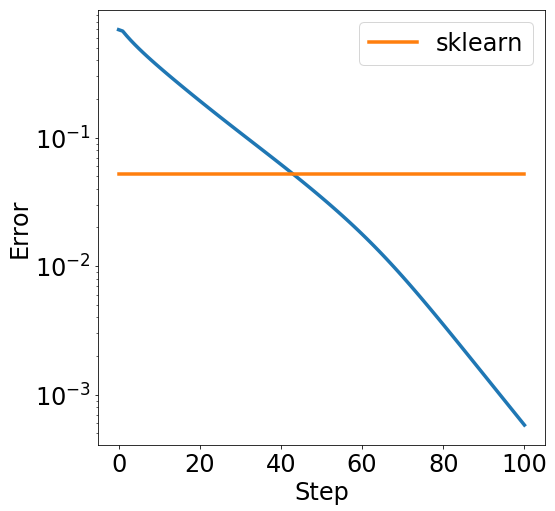

In [19]:
def line_search(x, d):
    """Constant step size."""
    return -0.1

ws_bfgs = bfgs(init, gradient, hessian, line_search, 100)
error_plot([log_likelihood(w, data, labels) for w in ws_bfgs])
plt.plot(range(len(ws_bfgs)), [baseline]*len(ws_bfgs),
        label='sklearn', **kwargs)
_ = plt.legend()

Now find a clever step size using the golden section search algorithm we discussed in a previous lecture.

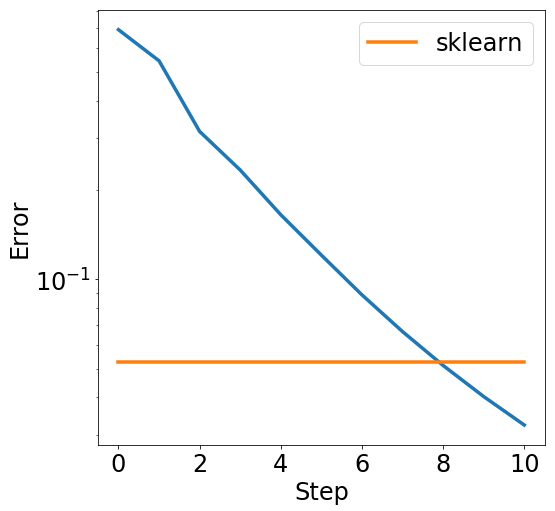

In [20]:
def line_search(x, d):
    return gss(lambda step: log_likelihood(x+step*d, data, labels), -1, 1)

ws_bfgs = bfgs(init, gradient, hessian, line_search, 10)
error_plot([log_likelihood(w, data, labels) for w in ws_bfgs])
plt.plot(range(len(ws_bfgs)), [baseline]*len(ws_bfgs),
        label='sklearn', **kwargs)
_ = plt.legend()

We see that BFGS with line search gets pretty close to Newton's method in iteration count, but each iteration is now much cheaper (in terms of the data dimension).

<a name="hvprod"></a>

## Hessian-vector products

Recall that we can implement the Hessian inverse (approximately or exactly) by just using Hessian vector products. This follows from the Krylov methods for solving linear equations.

This raises the question how we can, in general, compute Hessian-vector products of possibly complicated functions for which we have no exact formula for the Hessian.

Luckily, this problem is also solved by automatic differentiation. Let's import `autograd` first and define some function. For simplicity we'll reuse the log-likelihood we saw before.

In [21]:
import autograd.numpy as np
from autograd import grad

np.random.seed(1337)

In [22]:
def log_likelihood(weights, data, labels):
    """Normalized negative log likelihood."""
    scores = np.dot(data, weights)
    return -np.mean(labels*scores - np.log(1 + np.exp(scores)))

In [23]:
m, n = 1000, 100
data = np.random.normal(0, 1, (m, n))
wopt = np.random.normal(0, 1, n)
labels = (data.dot(wopt) > 0).astype(np.float)

Here's now how to get Hessian vector products with just two invocations of automatic differentiation.

In [24]:
objective = lambda w: log_likelihood(w, data, labels)

In [25]:
vector = np.random.normal(0, 1, n)
hvprod = grad(lambda x: np.dot(vector, grad(objective)(x)))

Let's verify that `hvprod` correctly implements the product of the Hessian at a given point with `vector`.

In [26]:
def log_likelihood_hessian(weights, data, labels):
    """Hessian of negative log likelihood."""
    predictions = logistic_model(weights, data)
    diag = np.diag(predictions * (1 - predictions))
    return data.T.dot(diag.dot(data))/len(data)

In [27]:
H = log_likelihood_hessian(wopt, data, labels)
np.allclose(hvprod(wopt), H.dot(vector))

True

<a name="adult"></a>

## Adult data set

Let's see how this all plays out on a more realistic data set, the [UCI adult data set](https://archive.ics.uci.edu/ml/datasets/adult). We'll first preprocess the data in a standard way.

In [28]:
import pandas as pd
import sklearn as skl
import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import sklearn.tree as tree

In [29]:
features = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"] 

# Source: https://archive.ics.uci.edu/ml/datasets/adult
original_train = pd.read_csv("adult.data.txt", names=features, sep=r'\s*,\s*', engine='python', na_values="?")
original_test = pd.read_csv("adult.test.txt", names=features, sep=r'\s*,\s*', engine='python', na_values="?", skiprows=1)

num_train = len(original_train)
original = pd.concat([original_train, original_test])
labels = original['Target']
labels = labels.replace('<=50K', 0).replace('>50K', 1)
labels = labels.replace('<=50K.', 0).replace('>50K.', 1)

# Redundant column
del original["Education"]
del original["Target"]

def data_transform(df):
    binary_data = pd.get_dummies(df)
    feature_cols = binary_data[binary_data.columns[:-2]]
    scaler = preprocessing.StandardScaler()
    data = pd.DataFrame(scaler.fit_transform(feature_cols), columns=feature_cols.columns)
    return data

data = data_transform(original)
train_data = data[:num_train]
train_labels = labels[:num_train]
test_data = data[num_train:]
test_labels = labels[num_train:]

In [30]:
len(train_data), len(test_data)

(32561, 16281)

In [31]:
original

,Age,Workclass,fnlwgt,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
5,37,Private,284582,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States
6,49,Private,160187,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica
7,52,Self-emp-not-inc,209642,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States
8,31,Private,45781,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States
9,42,Private,159449,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States


In [32]:
X = train_data.values
y = train_labels.values

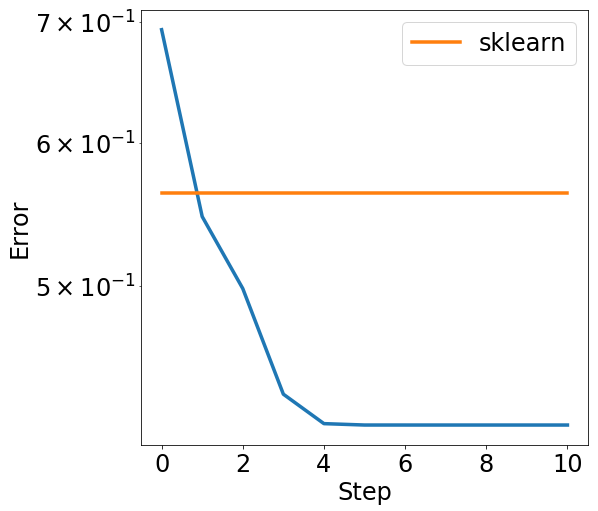

In [33]:
objective = lambda w: likelihood(w, X, y)
gradient = lambda w: log_likelihood_gradient(w, X, y)
hessian = lambda w: log_likelihood_hessian(w, X, y)
init = np.zeros(X.shape[1])

cls = linear_model.LogisticRegression()
cls.fit(X, y)
weights = np.reshape(cls.coef_, cls.coef_.shape[1])
baseline = log_likelihood(weights, X, y)

ws_newton = newton_method(init, np.ones(10), gradient, hessian)
error_plot([log_likelihood(w, X, y) for w in ws_newton])
plt.plot(range(len(ws_newton)), [baseline]*len(ws_newton),
        label='sklearn', **kwargs)
_ = plt.legend()

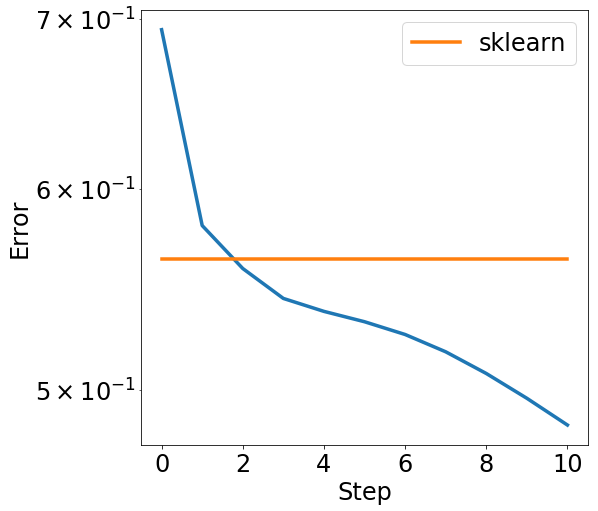

In [34]:
def line_search(x, d):
    return gss(lambda step: log_likelihood(x+step*d, X, y), -1, 1, tol=0.1)

ws_bfgs = bfgs(init, gradient, hessian, line_search, 10)
error_plot([log_likelihood(w, X, y) for w in ws_bfgs])
plt.plot(range(len(ws_bfgs)), [baseline]*len(ws_bfgs),
        label='sklearn', **kwargs)
_ = plt.legend()

### Timing comparison

In [35]:
timeit(lambda: linear_model.LogisticRegression().fit(X, y), number=1)

1.6104111671447754

In [36]:
timeit(lambda: bfgs(init, gradient, hessian, line_search, 10), number=1)

6.190078973770142

In [37]:
timeit(lambda: gradient_descent(init, np.ones(200), gradient), number=1)

1.7400920391082764

### Accuracy on the test set

In [38]:
Xtest = test_data.values
ytest = test_labels.values

In [39]:
def accuracy(weights):
    predictions = logistic_model(weights, Xtest)
    return np.mean((predictions > 0.5).astype(np.float) == ytest)

In [40]:
ws_gd = gradient_descent(init, np.ones(500), gradient)
accuracy(ws_gd[-1])

0.82636201707511825

In [41]:
ws_bfgs = bfgs(init, gradient, hessian, line_search, 20)
accuracy(ws_bfgs[-1])

0.83139856274184631

In [42]:
cls = linear_model.LogisticRegression(C=1, fit_intercept=False)
cls.fit(X, y)
cls.score(Xtest, ytest)
weights = np.reshape(cls.coef_, cls.coef_.shape[1])
accuracy(weights)

0.8308457711442786

We see that our toy implementation of BFGS is actually fairly competitive. So is gradient descent which reaches good test performance with an optimized constant step size.

## That's all. Thanks.